# Finding Period and Initial Best Fit

In [1]:
#Importing and notebook setup
%matplotlib inline
import os

#For Plotting
import matplotlib.pyplot as plt

#Numbers and Functions
import numpy as np
#Used to open excel file of data
import pandas as pd
#For Maximum Likelihood
from scipy import optimize
#For Periodogram
from gatspy.periodic import LombScargleFast

#Making Tables
from tabulate import tabulate

#for Radvel
import matplotlib
import pylab as pl

import corner

#importing radvel
import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Define Periodogram Function

In [2]:
def periodogram(datax, datay, min_, max_, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist) # Default 50

    #Plotting
    plt.figure
    plt.plot(period,power)
    plt.ylabel('Power')
    plt.xlabel('Period')# days
    plt.xscale('log')
    #used bottom line to zoom in periodogram
#     plt.xlim(min_-1,max_+10)

    # set range and find period
    model.optimizer.period_range=(min_, max_)
    period = model.best_period
    print("period = {0}".format(period))
    return period

Function for RadVel and Residuals

Define a Plotting Function to Display the Data, Model, and Residuals

In [3]:
#used for plotting radvel plots
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Define RMS Function

In [4]:
#getting RMS
def RMS (Residuals):
    RMS = np.std(Residuals)
    return RMS

Using Radvel to Find Model Likelihood

In [5]:
#Found in Radvel.Fitting
def model_likelihood(post,show=False):
    num_planet = post.likelihood.model.num_planets
    ndata = len(post.likelihood.y)
    nfree = len(post.get_vary_params())
    rms = np.std(post.likelihood.residuals())
    logprob = post.logprob()
    chi = np.sum((post.likelihood.residuals()/post.likelihood.errorbars())**2)
    chi_red = chi / (ndata - nfree)
    bic = post.bic()
    if show:
        print "N_free = %d" % nfree
        print "RMS = %4.2f" % np.std(post.likelihood.residuals())
        print "logprob (jitter fixed) = %4.2f" % post.logprob() #radvel.likelihood
        print "chi (jitter fixed) = %4.2f" % chi
        print "chi_red (jitter fixed) = %4.2f" % chi_red
        print "BIC (jitter fixed) = %4.2f" % post.bic()
        
    model_likelihood = [num_planet, ndata, nfree, rms, logprob, chi , chi_red, bic]
    return model_likelihood

My Own Method of Modeling Data

In [6]:
#My own method of plotting and finding likelihood
def residuals(num_planet,data_x, data_y,data_err,amplitude,period,phase_shift,vertical_shift):
    # Target function
    fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x
    #Distance to the target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y 
    
    # Initial guess for the first set's parameters
    p0 = [amplitude, period, phase_shift, vertical_shift]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(data_x, data_y))
    
    print 'Amplitude: ', np.absolute(p1[0])
    print 'Period: ', p1[1]
    print 'Phase Shift: ', p1[2]
    print 'Vertical-Shift: ',p1[3]
    period = p1[1]
    
    #Finding Residuals
    Residuals = data_y - fitfunc(p1,data_x)
    
    #Finding Likelihood
    ndata = len(data_x)
    nfree = 4.
    RMS = np.std(Residuals)
    logprob = np.log(np.sum(Residuals))
    chi = np.sum(((Residuals)/data_err)**2)
    chi_red = chi / (ndata - nfree)
#     bic = -2.0 * self.logprob() + len(self.likelihood.get_vary_params()) + np.log(len(self.likelihood.y))
    bic = np.log(ndata)+nfree +-2.*logprob
    #chisquared = sum(Residuals**2/(fitfunc(p1,data_x)))
    print "RMS of Residuals: ", RMS
    print "RMS", RMS
    print 'Chi Square', chi
    likelihood = [num_planet, ndata, nfree, RMS, logprob, chi , chi_red, bic]
    
    #Plotting Data with Fit
    time = np.linspace(data_x.min(), data_x.max(), 1000*len(data_x))
    plt.plot(data_x, data_y, "go", time, fitfunc(p1, time),"b-",alpha=0.5)
    plt.title('HD75732')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Data', 'Fit'))
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    ax1 = plt.axes()
    plt.show()
    
    #plotting Residuals
    #plt.plot(data_x, Residuals, "ro", time, fitfunc(p2, time),"b-")
    plt.plot(data_x, Residuals, "ro")
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    plt.ylim(-max(data_y)-10, max(data_y)+10)
    plt.title('Residuals')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Residuals', 'Fit'))
    ax2 = plt.axes()
    
    
    return Residuals, period, likelihood

Importing Data

In [9]:
#Data import
#here data_rj includes both rk data and rj data
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/research/HD75732/HD75732.csv')

#data from different telescopes
# data_rk = data[0:24]
# data_rj = data[24:655]


#Naming Variables from data
t = np.array(data.jd)
# vel_rk = np.array(data_rk.mnvel) + 60
# vel_rj = np.array(data_rj.mnvel)
# vel = np.append(vel_rk,vel_rj)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)


#time vector for best fit
ti = np.linspace(t.min(),t.max(),num=len(t)* 10000)
# print data
# print vel

# Finding Period in Data (1st Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1 to 5.5e+03
 - Computing periods at 27725 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 14.6518809412


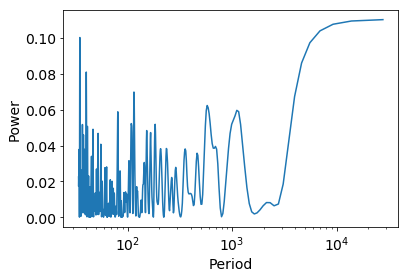

In [10]:
#nyquist - min period for data
nyquist = .5
#finding first planet period
period1 = periodogram(t,vel,1,max(t)-min(t),nyquist)

Initializing Radvel

In [11]:
nplanets = 1
instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = period1    # period of 1st planet
    params['tc1'] = 2074.52   # time of inferior conjunction of 1st planet
    params['secosw1'] = 0.01 
    params['sesinw1'] =  0.01 
    params['logk1'] =  np.log(50)   # velocity semi-amplitude for 1st planet  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

In [12]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

# like.params['gamma_k'] = 0.0
# like.params['gamma_j'] = 1.0
# like.params['jit_k'] = 2.6
# like.params['jit_j'] = 2.6

Defining Variables that are Going to Vary.

In [13]:
like.vary['curv'] = True
like.vary['dvdt'] = True
#like.vary['per1'] = False
#like.vary['logk1'] = False
#like.vary['secosw1'] = False
#like.vary['sesinw1'] = False
#like.vary['tc1'] = False

Plotting Radvels Initial Likelihood

C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


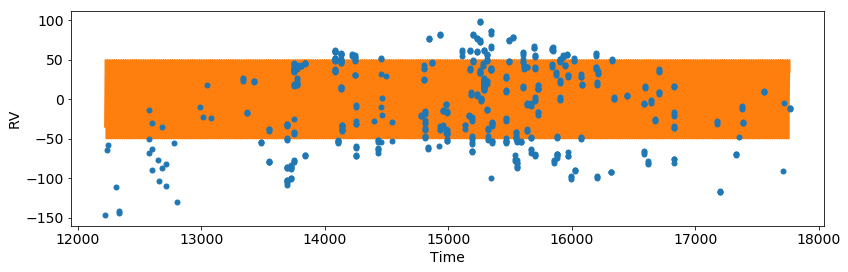

In [14]:
pl.figure()
plot_results(like)
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

Maximize the Likelihood and Print the Updated Posterior Object

In [15]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_k', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_j', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6519       True
tc1                         2074.52       True
secosw1                        0.01       True
sesinw1                        0.01       True
logk1                       3.91202       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6518809412, sigma=3.6629702353
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



parameter                     value      vary
per1                        14.6518       True
tc1                         2074.51       True
secosw1                    0.137389       True
sesinw1                   -0.121821       True
logk1                       4.18196       True
dvdt                   -0.000843897       True
curv                    2.62468e-09       True
jit                         23.8404       True
gamma                     -0.710821       True

Priors
------
Gaussian prior on per1, mu=14.6518809412, sigma=3.6629702353
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(<matplotlib.figure.Figure at 0xd995e48>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1dce18d0>])

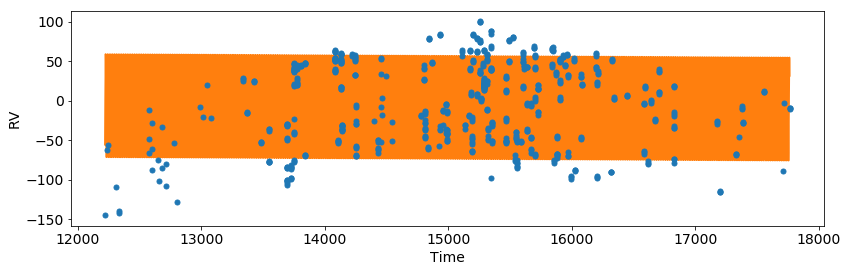

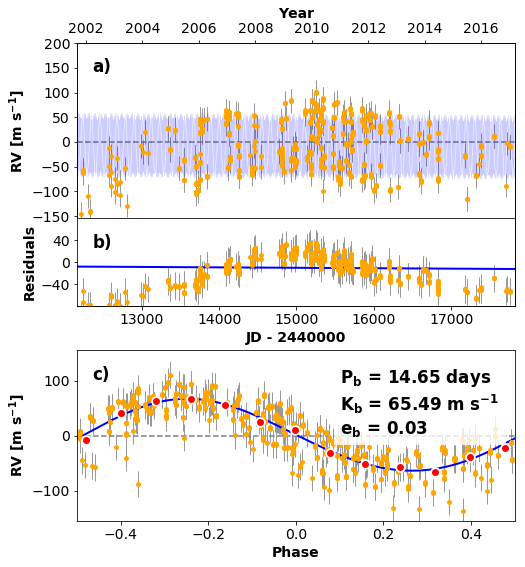

In [16]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
#Get residuals
#orbel = []
#radvel.kepler.rv_drive(t)
plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post,epoch=2440000)

In [20]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

Finding the Model Likelihood, using RMS, Chi Squared, Log Probability, & BIC

In [21]:
Residuals_Radvel_1 = post.likelihood.residuals()
RMS_Radvel_1 = RMS(Residuals_Radvel_1)
print 'Radvel RMS of Residuals: ', RMS_Radvel_1
print ' '
print ' '

one_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  25.2979699951
 
 
N_free = 9
RMS = 25.30
logprob (jitter fixed) = -3081.65
chi (jitter fixed) = 734.50
chi_red (jitter fixed) = 1.14
BIC (jitter fixed) = 6178.78


# ***********Attempting to use Multiple Data***********

In [22]:
# http://radvel.readthedocs.io/en/master/_modules/radvel/plotting.html?highlight=tel
# Using Radvel.fitting
# not sure what "ax" is on arguments
# not sure how to use "telfmts_default[ ]" 

#dictionary for telescopes
# telfmts_default = {
#     'j': dict(color='r',fmt='o',mfc='none',label='HIRES',mew=1),
#     'k': dict(color='g',fmt='s',mfc='none',label='HIRES pre 2004',mew=1),
#     'a': dict(color='g',fmt='d',label='APF'),
#     'pfs': dict(color='magenta',fmt='p',label='PFS'),
#     'h': dict(color='firebrick',fmt="s",label='HARPS'),
#     'harps-n': dict(color='firebrick',fmt='^',label='HARPS-N'),
#     'l': dict(color='g',fmt='*'),
# }

# telfmts_default['lick'] = telfmts_default['l']
# telfmts_default['hires_rj'] = telfmts_default['j']
# telfmts_default['hires'] = telfmts_default['j']
# telfmts_default['hires_rk'] = telfmts_default['k']
# telfmts_default['apf'] = telfmts_default['a']
# telfmts_default['harps'] = telfmts_default['h']
# print telfmts_default
# type( radvel.plotting.telfmts_default)
# radvel.plotting._mtelplot()
# print radvel.plotting.telfmts_default
# radvel.plotting.rv_multipanel_plot(post,epoch=2440000,telfmts=radvel.plotting.telfmts_default)
# print post

# Initial Best Fit My Own Way (1st Planet)

Finding Model for Data

Amplitude:  65.3575750861
Period:  14.6521455341
Phase Shift:  1.14942761881
Vertical-Shift:  -0.000695870935594
RMS of Residuals:  25.3438755979
RMS 25.3438755979
Chi Square 391846.761711


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


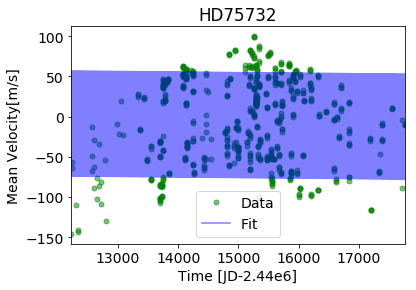

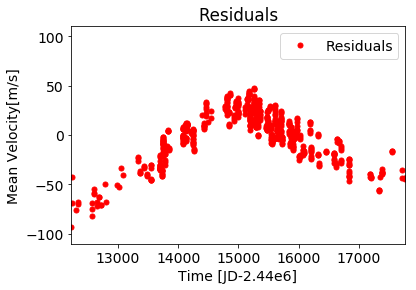

In [23]:
guess_amp = 50.
guess_pshft =0.
guess_vshft = 0.
residuals1, period1, likelihood1 = residuals(nplanets,t,vel,errvel,guess_amp,period1,guess_pshft,guess_vshft)

# Finding Period for 2nd Planet

Looking at Residuals for another Period

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1 to 5.5e+03
 - Computing periods at 27725 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 4987.19985612


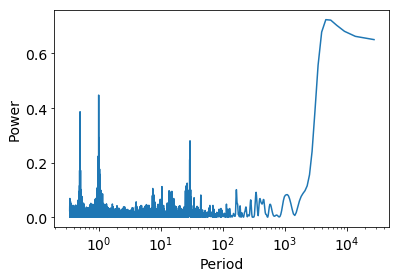

In [24]:
period_radvel_2 = periodogram(t,Residuals_Radvel_1,1,max(t)-min(t),50)

In [25]:
nplanets = 2
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = period_radvel_2 
    params['tc2'] =  4268.95 + 1000   
    params['secosw2'] = 0.01  
    params['sesinw2'] = 0.01 
    params['logk2'] = np.log(RMS_Radvel_1)   
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

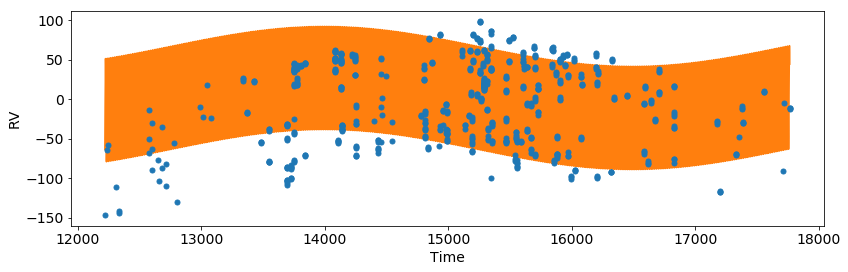

In [26]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [27]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6518       True
tc1                         2074.51       True
secosw1                    0.137389       True
sesinw1                   -0.121821       True
logk1                       4.18196       True
per2                         4987.2       True
tc2                         5268.95       True
secosw2                        0.01       True
sesinw2                        0.01       True
logk2                       3.23072       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6517753759, sigma=3.66294384396
Gaussian prior on per2, mu=4987.19985612, sigma=1246.79996403
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1881: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


parameter                     value      vary
per1                        14.6514       True
tc1                         2074.83       True
secosw1                    0.096618       True
sesinw1                   0.0883004       True
logk1                        4.2503       True
per2                        5442.83       True
tc2                         5117.97       True
secosw2                    0.377379       True
sesinw2                   -0.173583       True
logk2                       3.71219       True
dvdt                    -0.00249685       True
curv                    2.80374e-07       True
jit                          11.052       True
gamma                      -42.1059       True

Priors
------
Gaussian prior on per1, mu=14.6517753759, sigma=3.66294384396
Gaussian prior on per2, mu=4987.19985612, sigma=1246.79996403
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



(<matplotlib.figure.Figure at 0x28919780>,
  <matplotlib.axes._subplots.AxesSubplot at 0xdb43e10>])

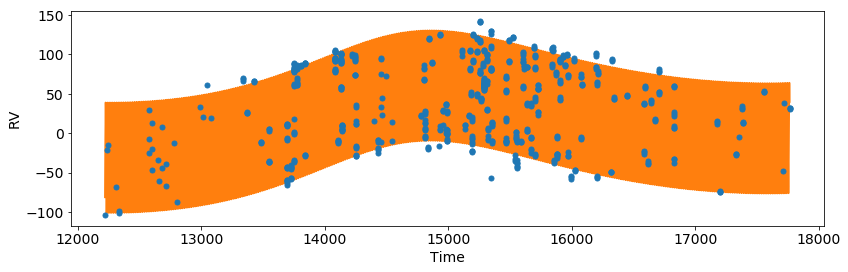

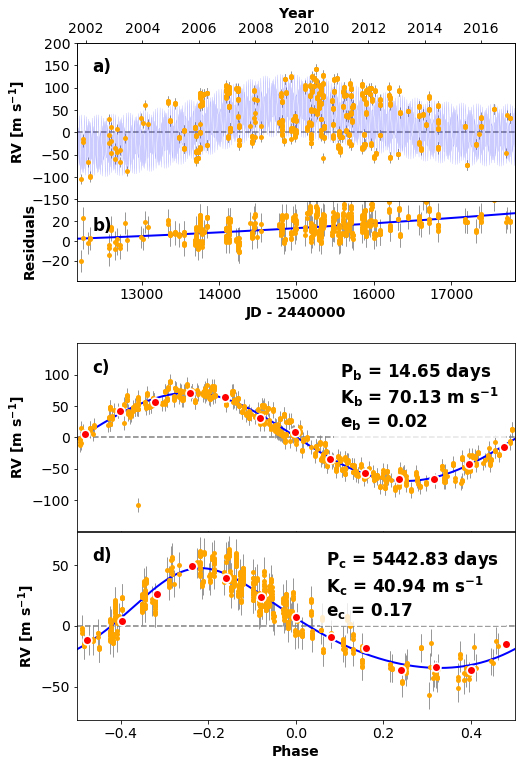

In [28]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [29]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [30]:
Residuals_Radvel_2 = post.likelihood.residuals()
RMS_Radvel_2 = RMS(Residuals_Radvel_2)
print 'Radvel RMS of Residuals: ', RMS_Radvel_2
print ' '
print ' '

#Model Likelihood
two_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  11.4320454172
 
 
N_free = 14
RMS = 11.43
logprob (jitter fixed) = -2524.39
chi (jitter fixed) = 682.06
chi_red (jitter fixed) = 1.07
BIC (jitter fixed) = 5069.26


# Initial Best Fit My Own Way (2nd Planet)

Period for my own method

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1 to 5.5e+03
 - Computing periods at 27725 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 5032.45575318


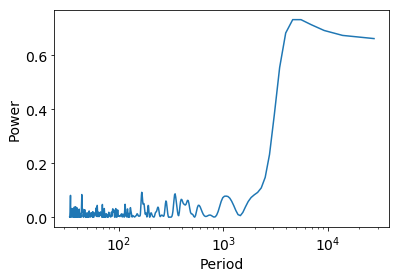

In [31]:
period2 = periodogram(t,residuals1,1,max(t)-min(t),nyquist)

Amplitude:  36.5384408208
Period:  4973.50533255
Phase Shift:  -0.16802077228
Vertical-Shift:  -0.000977480007122
RMS of Residuals:  13.2856523197
RMS 13.2856523197
Chi Square 94341.3428481


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


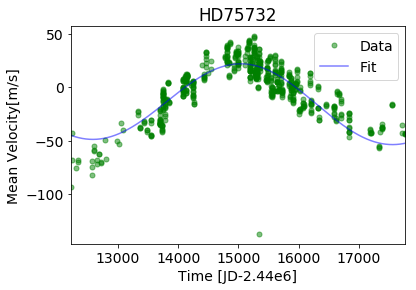

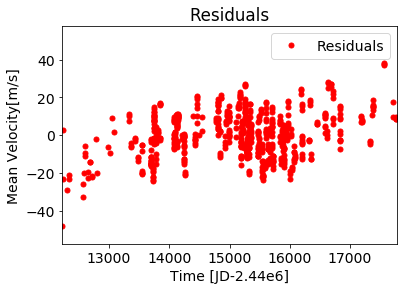

In [32]:
guess_amp = 30.
guess_pshft = 0.
guess_vshft = 0.
residuals2, period2, likelihood2 = residuals(nplanets, t, residuals1, errvel, guess_amp, period2, guess_pshft, guess_vshft)

# Finding Period for Planet 3

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1 to 5.5e+03
 - Computing periods at 27725 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.4215680369


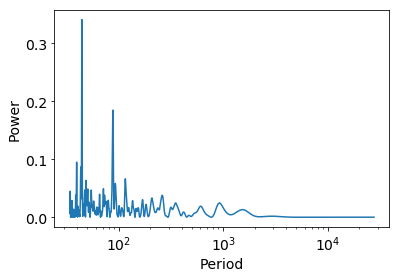

In [33]:
period_radvel_3 = periodogram(t,Residuals_Radvel_2,1,max(t)-min(t),nyquist)

In [34]:
nplanets = 3
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2'] 

    #3rd Planet
    params['per3'] = period_radvel_3
    params['tc3'] = 2087.07 
    params['secosw3'] = 0.01
    params['sesinw3'] =  0.01 
    params['logk3'] = np.log(RMS_Radvel_2)
    
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

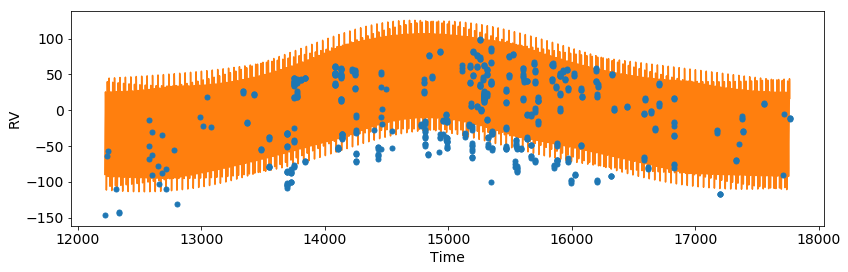

In [35]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [36]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6514       True
tc1                         2074.83       True
secosw1                    0.096618       True
sesinw1                   0.0883004       True
logk1                        4.2503       True
per2                        5442.83       True
tc2                         5117.97       True
secosw2                    0.377379       True
sesinw2                   -0.173583       True
logk2                       3.71219       True
per3                        44.4216       True
tc3                         2087.07       True
secosw3                        0.01       True
sesinw3                        0.01       True
logk3                       2.43642       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6514186635, sigm

parameter                     value      vary
per1                        14.6515       True
tc1                          2074.8       True
secosw1                   0.0212403       True
sesinw1                   0.0935791       True
logk1                       4.24863       True
per2                         5564.3       True
tc2                         5131.71       True
secosw2                    0.252914       True
sesinw2                   -0.356618       True
logk2                       3.71083       True
per3                        43.7621       True
tc3                         2086.98       True
secosw3                    0.572843       True
sesinw3                   -0.803015       True
logk3                       3.03444       True
dvdt                    -0.00181481       True
curv                    7.00596e-08       True
jit                         10.8861       True
gamma                      -17.6231       True

Priors
------
Gaussian prior on per1, mu=14.6514186635, sigm

(<matplotlib.figure.Figure at 0x288c83c8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1195ea58>])

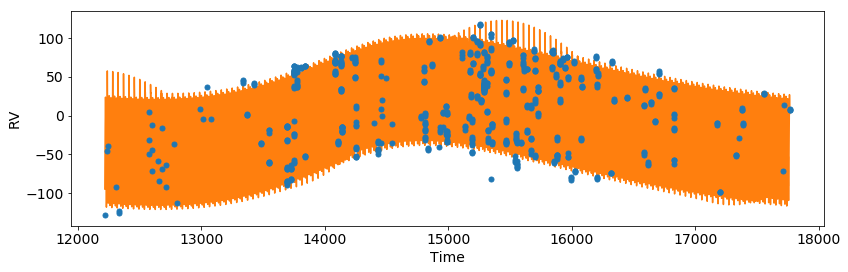

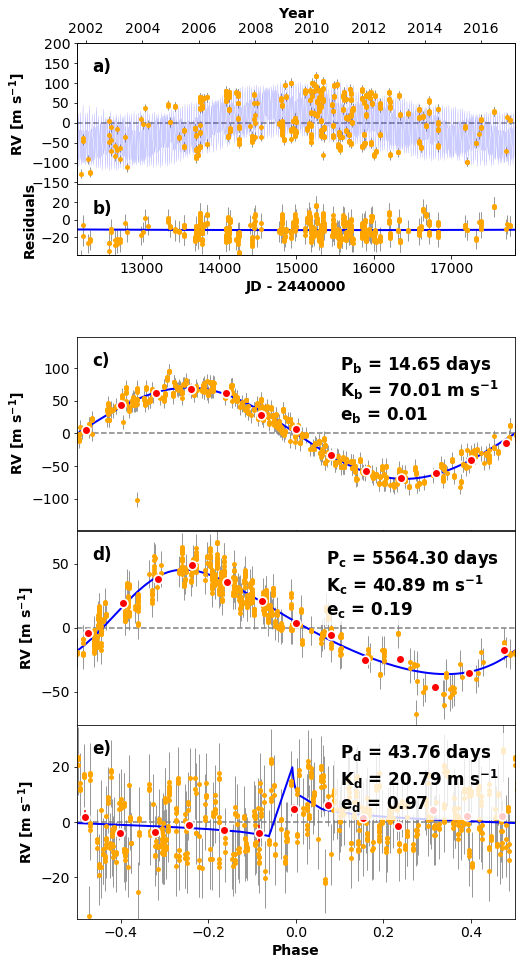

In [37]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [38]:
# radvel.plotting.rv_multipanel_plot(post,epoch=2440000,telfmts={})

In [39]:
Residuals_Radvel_3 = post.likelihood.residuals()
RMS_Radvel_3 = RMS(Residuals_Radvel_3)
print 'Radvel RMS of Residuals: ', RMS_Radvel_3
print ' '
print ' '

#model likelihood
three_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  11.2568942488
 
 
N_free = 19
RMS = 11.26
logprob (jitter fixed) = -2513.99
chi (jitter fixed) = 681.50
chi_red (jitter fixed) = 1.07
BIC (jitter fixed) = 5053.46


# Initial Best Fit My Own Way (3rd Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1 to 5.5e+03
 - Computing periods at 27725 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.3952532061


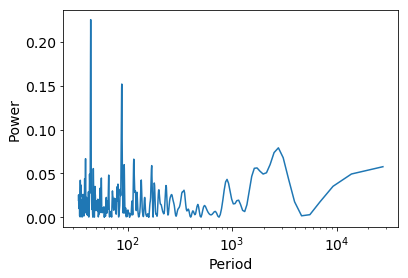

In [40]:
period3 = periodogram(t,residuals2,1,max(t)-min(t),nyquist)

Amplitude:  8.71376153088
Period:  44.3934286753
Phase Shift:  -4.51281037398
Vertical-Shift:  1.65263086201e-05
RMS of Residuals:  11.7246620775
RMS 11.7246620775
Chi Square 66279.674427


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


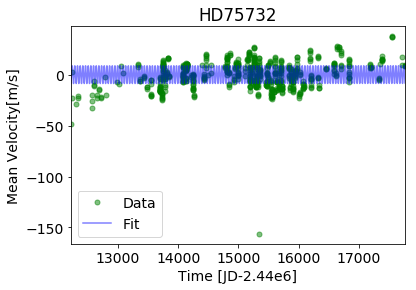

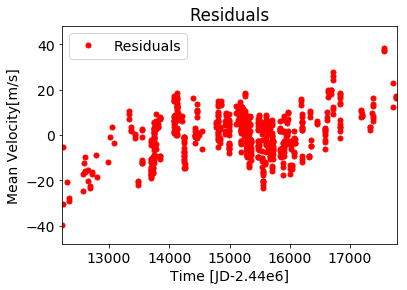

In [41]:
guess_amp = 20.
guess_pshft =0.
guess_vshft = 0.
residuals3, period3, likelihood3 = residuals(nplanets, t, residuals2, errvel, guess_amp, period3, guess_pshft, guess_vshft)

# Finding 4th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1 to 5.5e+03
 - Computing periods at 27725 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.4144528447


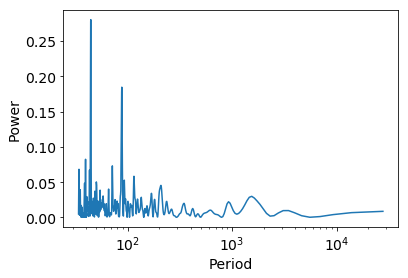

In [42]:
period_radvel_4 = periodogram(t,Residuals_Radvel_3,1,max(t)-min(t),nyquist)

In [43]:
nplanets = 4
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = period_radvel_4
    params['tc4'] = 2087.07 -1000   
    params['secosw4'] = 0.01
    params['sesinw4'] = 0.01
    params['logk4'] = np.log(RMS_Radvel_3)   
 
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

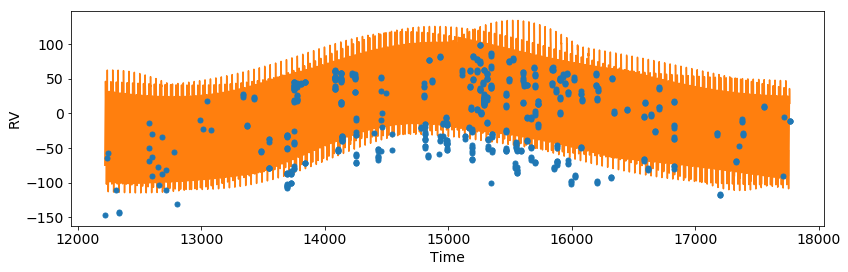

In [44]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [45]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6515       True
tc1                          2074.8       True
secosw1                   0.0212403       True
sesinw1                   0.0935791       True
logk1                       4.24863       True
per2                         5564.3       True
tc2                         5131.71       True
secosw2                    0.252914       True
sesinw2                   -0.356618       True
logk2                       3.71083       True
per3                        43.7621       True
tc3                         2086.98       True
secosw3                    0.572843       True
sesinw3                   -0.803015       True
logk3                       3.03444       True
per4                        44.4145       True
tc4                         1087.07       True
secosw4                        0.01       True
sesinw4                        0.01       True
logk4                       2.42098       True
dvdt          

C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1877: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1878: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


parameter                     value      vary
per1                        14.6515       True
tc1                         2074.79       True
secosw1                  0.00766643       True
sesinw1                   0.0910581       True
logk1                       4.24578       True
per2                        5666.43       True
tc2                         4942.07       True
secosw2                    0.241428       True
sesinw2                   -0.360348       True
logk2                       3.72729       True
per3                        43.7624       True
tc3                         2086.76       True
secosw3                    0.568376       True
sesinw3                   -0.802375       True
logk3                        2.9871       True
per4                        46.5835       True
tc4                         1085.69       True
secosw4                   -0.978037       True
sesinw4                    0.182874       True
logk4                       3.30594       True
dvdt          

(<matplotlib.figure.Figure at 0x259570f0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x253bf048>])

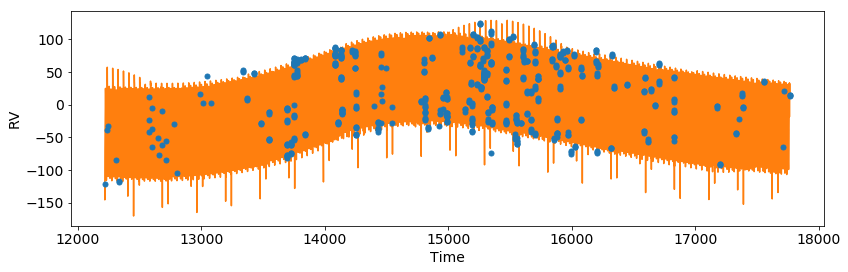

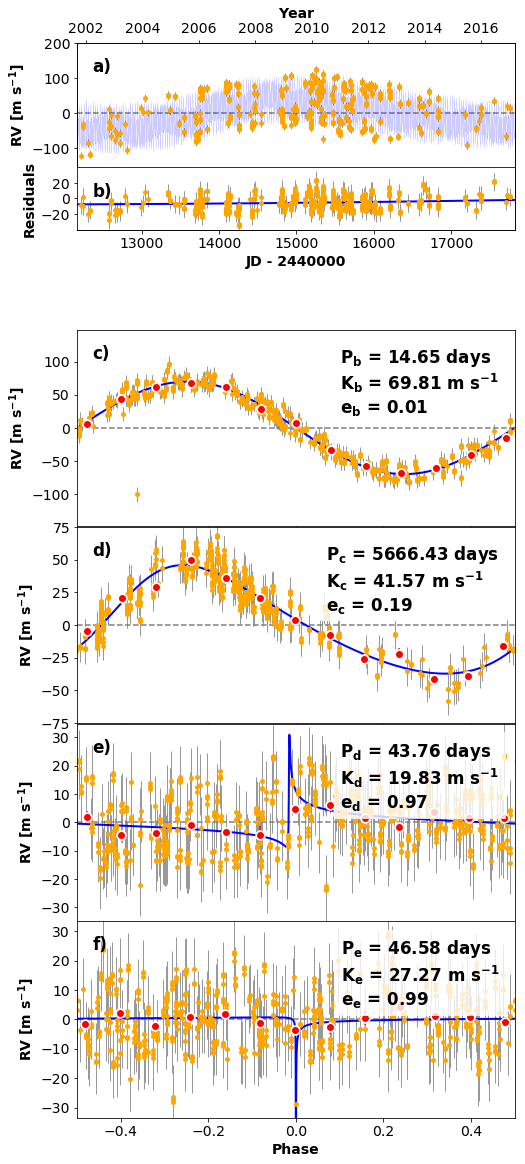

In [46]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [47]:
# radvel.plotting.rv_multipanel_plot(post,epoch=2440000,telfmts={})

In [48]:
Residuals_Radvel_4 = post.likelihood.residuals()
RMS_Radvel_4 = RMS(Residuals_Radvel_4)
print 'Radvel RMS of Residuals: ', RMS_Radvel_4
print ' '
print ' '

#model likelihood
four_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  11.0929938364
 
 
N_free = 24
RMS = 11.09
logprob (jitter fixed) = -2504.03
chi (jitter fixed) = 681.36
chi_red (jitter fixed) = 1.08
BIC (jitter fixed) = 5038.54


# Initial Best Fit My Own Way (4th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1 to 5.5e+03
 - Computing periods at 27725 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81740945909


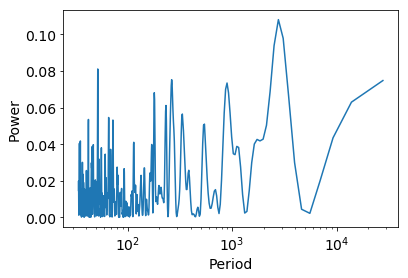

In [49]:
period4 = periodogram(t,residuals3,1,max(t)-min(t),nyquist)

Amplitude:  5.9258758799
Period:  2.81740531018
Phase Shift:  0.44155790995
Vertical-Shift:  1.27606630922e-05
RMS of Residuals:  10.9188412496
RMS 10.9188412496
Chi Square 55176.3993708


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


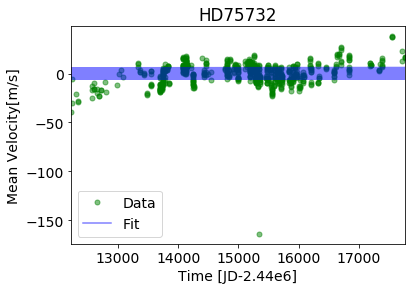

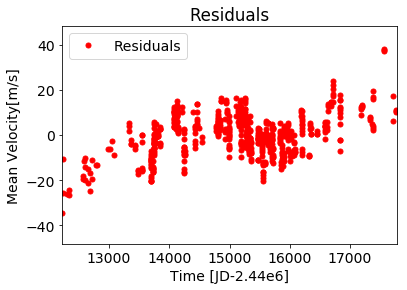

In [50]:
guess_amp = 15.
guess_pshft =0.
guess_vshft = 0.
residuals4, period4, likelihood4 = residuals(nplanets, t, residuals3, errvel, guess_amp, period4, guess_pshft, guess_vshft)

# 5th Planet Period

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1.1 to 5.5e+03
 - Computing periods at 25205 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.4187216865


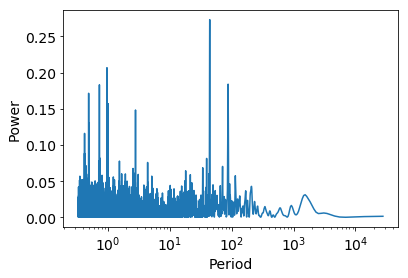

In [51]:
# the highest peak in this graph actually is the alius period, but I usually filter my search for a period by making
# the minimum value to output to be greater than a day. This is due to data usually being sampled periodically at minimum
# of one day.
period_radvel_5 = periodogram(t,Residuals_Radvel_4,1.1,max(t)-min(t),50)

period_radvel_5 = 259.7

In [52]:
nplanets = 5
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = period_radvel_5
    params['tc5'] = 2087.07  
    params['secosw5'] = 0.01
    params['sesinw5'] = 0.01
    params['logk5'] = np.log(RMS_Radvel_4)  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

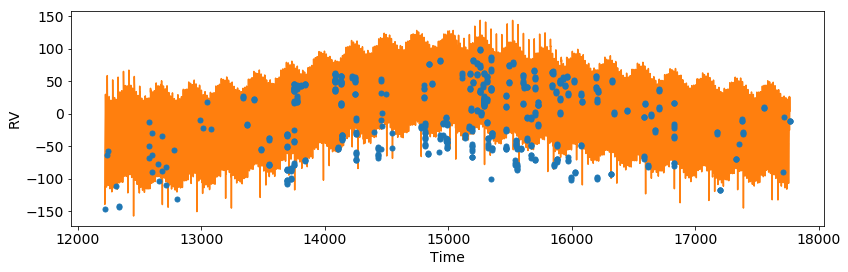

In [53]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [54]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6515       True
tc1                         2074.79       True
secosw1                  0.00766643       True
sesinw1                   0.0910581       True
logk1                       4.24578       True
per2                        5666.43       True
tc2                         4942.07       True
secosw2                    0.241428       True
sesinw2                   -0.360348       True
logk2                       3.72729       True
per3                        43.7624       True
tc3                         2086.76       True
secosw3                    0.568376       True
sesinw3                   -0.802375       True
logk3                        2.9871       True
per4                        46.5835       True
tc4                         1085.69       True
secosw4                   -0.978037       True
sesinw4                    0.182874       True
logk4                       3.30594       True
per5          

parameter                     value      vary
per1                        14.6516       True
tc1                          2074.8       True
secosw1                  -0.0533689       True
sesinw1                    0.121243       True
logk1                       4.24428       True
per2                        5641.76       True
tc2                         5000.62       True
secosw2                    0.264498       True
sesinw2                   -0.399904       True
logk2                       3.69784       True
per3                        43.7554       True
tc3                         2086.73       True
secosw3                    0.569782       True
sesinw3                   -0.802614       True
logk3                       2.88725       True
per4                         44.623       True
tc4                          1085.8       True
secosw4                   -0.974296       True
sesinw4                    0.201859       True
logk4                       4.42516       True
per5          

(<matplotlib.figure.Figure at 0x19753160>,
  <matplotlib.axes._subplots.AxesSubplot at 0x25a03be0>])

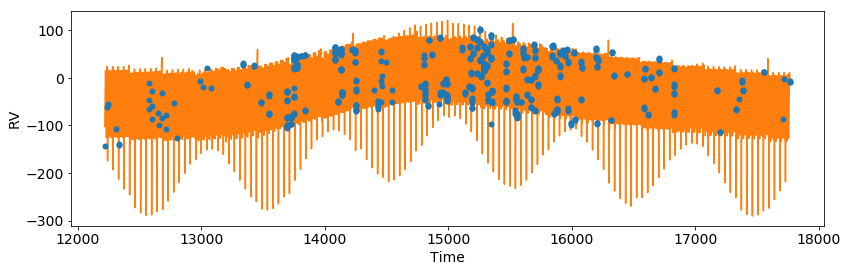

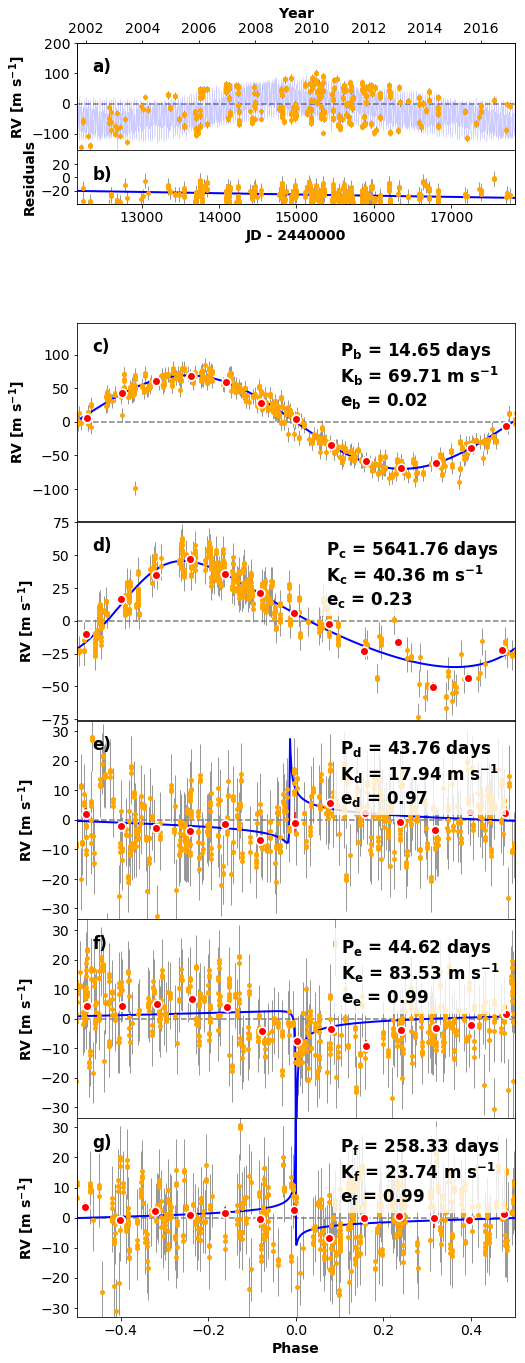

In [55]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [56]:
# radvel.plotting.rv_multipanel_plot(post,epoch=2440000,telfmts={})

In [57]:
Residuals_Radvel_5 = post.likelihood.residuals()
RMS_Radvel_5 = RMS(Residuals_Radvel_5)
print 'Radvel RMS of Residuals: ', RMS_Radvel_5
print ' '
print ' '

#model likelihood
five_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  10.7728300422
 
 
N_free = 29
RMS = 10.77
logprob (jitter fixed) = -2483.91
chi (jitter fixed) = 681.85
chi_red (jitter fixed) = 1.09
BIC (jitter fixed) = 5003.31


# Initial Best Fit My Own Way (5th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  15 to 1.5e+03
 - Computing periods at 1832 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 24.9702235888


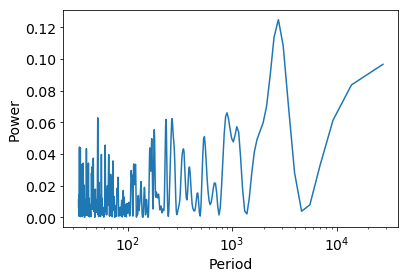

In [58]:
period5 = periodogram(t,residuals4,15,1500,nyquist)

Amplitude:  4.27943442276
Period:  24.971819679
Phase Shift:  -0.396098775736
Vertical-Shift:  -1.18357377477e-05
RMS of Residuals:  10.4847789912
RMS 10.4847789912
Chi Square 48922.3136896


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


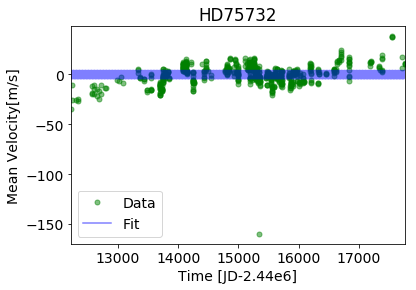

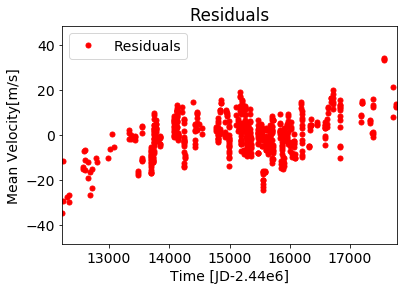

In [59]:
guess_amp = 10.
guess_pshft =0.
guess_vshft = 0.
residuals5, period5, likelihood5 = residuals(nplanets, t, residuals4, errvel, guess_amp, period5, guess_pshft, guess_vshft)

# Possible 6th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  1.2 to 2e+02
 - Computing periods at 22970 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.3665447649


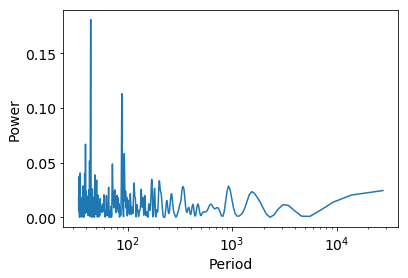

In [60]:
period_radvel_6 = periodogram(t,Residuals_Radvel_5,1.2,200,nyquist)

In [61]:
nplanets = 6
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = post.params['per5']
    params['tc5'] = post.params['tc5']
    params['secosw5'] = post.params['secosw5']
    params['sesinw5'] = post.params['sesinw5']
    params['logk5'] = post.params['logk5'] 
    
    #6th Planet
    params['per6'] = period_radvel_6
    params['tc6'] = 2087.07  
    params['secosw6'] = 0.01
    params['sesinw6'] = 0.01
    params['logk6'] = np.log(RMS_Radvel_5) 

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

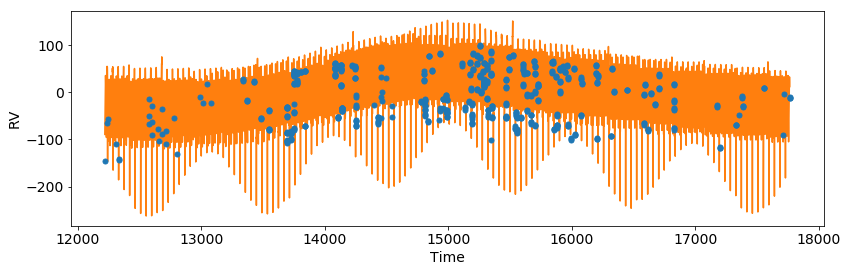

In [62]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [63]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]
post.priors += [radvel.prior.Gaussian('per6',like.params['per6'],.25*like.params['per6'])]


post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6516       True
tc1                          2074.8       True
secosw1                  -0.0533689       True
sesinw1                    0.121243       True
logk1                       4.24428       True
per2                        5641.76       True
tc2                         5000.62       True
secosw2                    0.264498       True
sesinw2                   -0.399904       True
logk2                       3.69784       True
per3                        43.7554       True
tc3                         2086.73       True
secosw3                    0.569782       True
sesinw3                   -0.802614       True
logk3                       2.88725       True
per4                         44.623       True
tc4                          1085.8       True
secosw4                   -0.974296       True
sesinw4                    0.201859       True
logk4                       4.42516       True
per5          

parameter                     value      vary
per1                        14.6516       True
tc1                         2074.79       True
secosw1                  -0.0243073       True
sesinw1                    0.142606       True
logk1                        4.2608       True
per2                        5665.58       True
tc2                         4998.21       True
secosw2                    0.229807       True
sesinw2                   -0.398371       True
logk2                       3.72151       True
per3                        43.7533       True
tc3                         2086.76       True
secosw3                    0.584254       True
sesinw3                   -0.805386       True
logk3                       3.10057       True
per4                        45.5121       True
tc4                         1085.57       True
secosw4                   -0.974311       True
sesinw4                    0.201786       True
logk4                        3.9405       True
per5          

(<matplotlib.figure.Figure at 0x18e46080>,
  <matplotlib.axes._subplots.AxesSubplot at 0x2702eba8>])

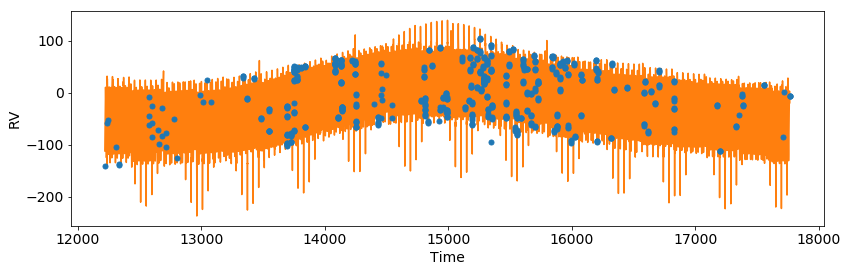

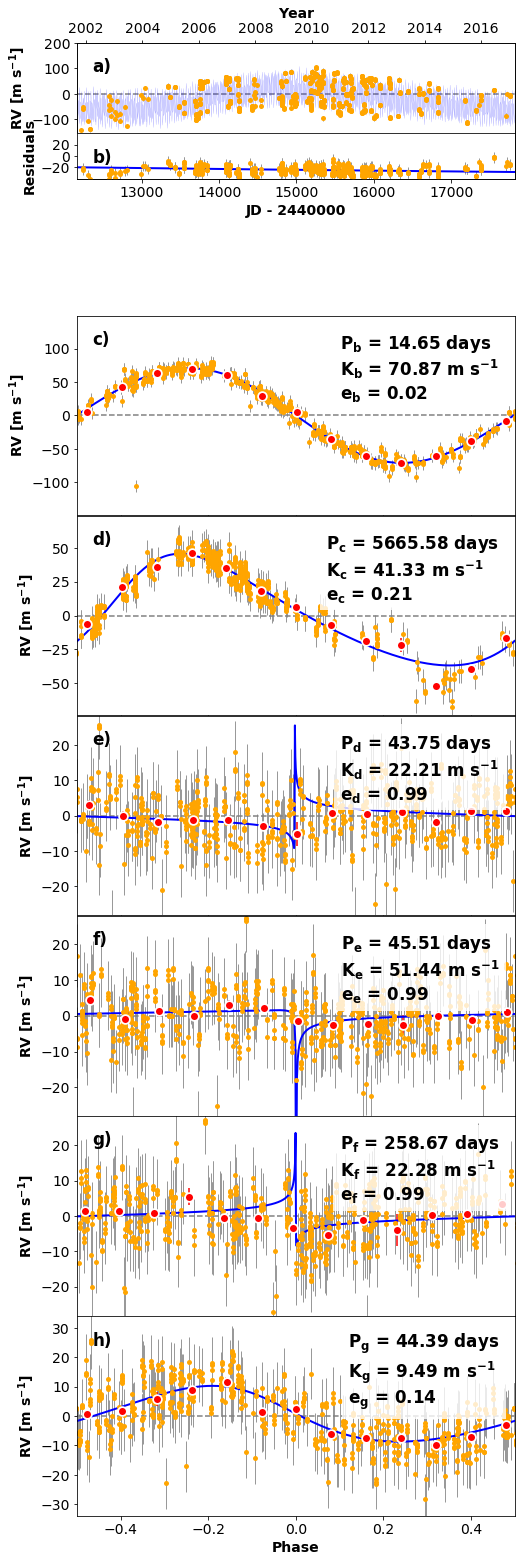

In [64]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [65]:
Residuals_Radvel_6 = post.likelihood.residuals()
RMS_Radvel_6 = RMS(Residuals_Radvel_6)
print 'Radvel RMS of Residuals: ', RMS_Radvel_6
print ' '
print ' '

#model likelihood
six_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  9.15216493795
 
 
N_free = 34
RMS = 9.15
logprob (jitter fixed) = -2367.78
chi (jitter fixed) = 692.06
chi_red (jitter fixed) = 1.12
BIC (jitter fixed) = 4776.04


# Initial Best Fit My Own Way (6th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  15 to 1e+03
 - Computing periods at 1822 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 24.7915565557


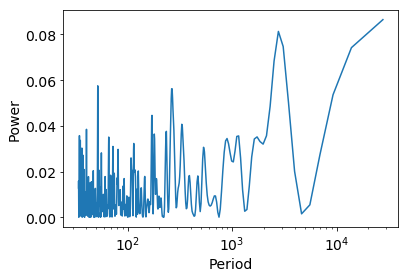

In [66]:
period6 = periodogram(t,residuals5,15,1000,nyquist)

Amplitude:  3.82010559324
Period:  24.7918001689
Phase Shift:  -0.175320408144
Vertical-Shift:  1.45131778615e-05
RMS of Residuals:  10.1243396611
RMS 10.1243396611
Chi Square 43575.7338261


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


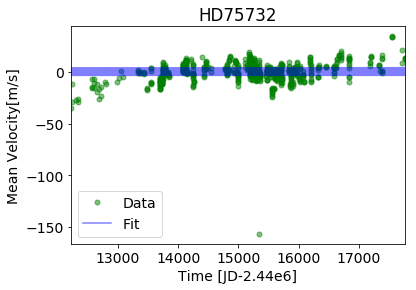

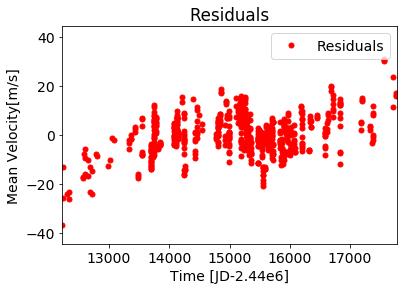

In [67]:
guess_amp = 10.
guess_pshft =0.
guess_vshft = 0.
residuals6, period6, likelihood6 = residuals(nplanets, t, residuals5, errvel, guess_amp, period6, guess_pshft, guess_vshft)

# Results

Periods of all Planets

In [68]:
header_likely = ['Method','1st Planet','2nd Planet', '3rd Planet', '4th Planet', '5th Planet', '6th Planet']
radvel_periods = ['Radvel',period1,period_radvel_2,period_radvel_3,period_radvel_4,period_radvel_5,period_radvel_6]
own_periods = ['Own',period1,period2,period3, period4,period5,period6]
print 'PERIODS FOR PLANETS'
print ''
print tabulate([radvel_periods, own_periods],headers=header_likely)

PERIODS FOR PLANETS

Method      1st Planet    2nd Planet    3rd Planet    4th Planet    5th Planet    6th Planet
--------  ------------  ------------  ------------  ------------  ------------  ------------
Radvel         14.6521       4987.2        44.4216      44.4145       259.7          44.3665
Own            14.6521       4973.51       44.3934       2.81741       24.9718       24.7918


Model Comparison using Radvel

In [69]:
header_likely = ['num_planets','# Data', 'Free Params', 'RMS', 'Logprob', 'chi', 'chi_red', 'BIC']
print 'MODEL COMPARISON RADVEL'
print ''
print tabulate([one_planet,two_planet,three_planet,four_planet,five_planet,six_planet],headers=header_likely)

MODEL COMPARISON RADVEL

  num_planets    # Data    Free Params       RMS    Logprob      chi    chi_red      BIC
-------------  --------  -------------  --------  ---------  -------  ---------  -------
            1       654              9  25.298     -3081.65  734.505    1.13877  6178.78
            2       654             14  11.432     -2524.39  682.062    1.06572  5069.26
            3       654             19  11.2569    -2513.99  681.5      1.07323  5053.46
            4       654             24  11.093     -2504.03  681.357    1.08152  5038.54
            5       654             29  10.7728    -2483.91  681.85     1.09096  5003.31
            6       654             34   9.15216   -2367.78  692.065    1.11623  4776.04


Model Comparison using my own method

In [70]:
print 'MODEL COMPARISON FOR OWN METHOD'
print ''
print tabulate([likelihood1,likelihood2,likelihood3,likelihood4,likelihood5,likelihood6],headers=header_likely)

MODEL COMPARISON FOR OWN METHOD

  num_planets    # Data    Free Params      RMS    Logprob       chi    chi_red    BIC
-------------  --------  -------------  -------  ---------  --------  ---------  -----
            1       654              4  25.3439        nan  391847     602.841     nan
            2       654              4  13.2857        nan   94341.3   145.141     nan
            3       654              4  11.7247        nan   66279.7   101.969     nan
            4       654              4  10.9188        nan   55176.4    84.8868    nan
            5       654              4  10.4848        nan   48922.3    75.2651    nan
            6       654              4  10.1243        nan   43575.7    67.0396    nan


# Ignore Everything Below This

Define a function that we will use to initialize the ``radvel.RVParameters`` and ``radvel.RVModel`` objects

curv                   -7.39154e-08       True
dvdt                   -0.000573222       True
gamma                       4.61095       True
jit                         11.2417       True
logk1                       4.24819       True
logk2                       3.42597       True
per1                        14.6521       True
per2                        3901.48       True
secosw1                   0.0647091       True
secosw2                   0.0836947       True
sesinw1                     0.10735       True
sesinw2                   -0.419884       True
tc1                         2074.21       True
tc2                         4268.95       True

# MCMC Chain

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.

In [71]:
# df = radvel.mcmc(post,nwalkers=50,nrun=5000)

Now lets make a corner plot to display the posterior distributions.

In [72]:
# radvel.plotting.corner_plot(post, df)

In [73]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [74]:
"""
df['k1'] = np.exp(df['logk1'])
df['k2'] = np.exp(df['logk2'])
df['k3'] = np.exp(df['logk3'])
df['k4'] = np.exp(df['logk4'])
df['jit'] = np.exp(df['jit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2
df['e3'] = df['secosw3']**2 + df['sesinw3']**2
df['e4'] = df['secosw4']**2 + df['sesinw4']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])

df['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])
df['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])

df['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])
df['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])

labels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84,]
    )
"""

"\ndf['k1'] = np.exp(df['logk1'])\ndf['k2'] = np.exp(df['logk2'])\ndf['k3'] = np.exp(df['logk3'])\ndf['k4'] = np.exp(df['logk4'])\ndf['jit'] = np.exp(df['jit'])\ndf['e1'] = df['secosw1']**2 + df['sesinw1']**2\ndf['e2'] = df['secosw2']**2 + df['sesinw2']**2\ndf['e3'] = df['secosw3']**2 + df['sesinw3']**2\ndf['e4'] = df['secosw4']**2 + df['sesinw4']**2\n\ndf['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])\ndf['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])\n\ndf['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])\ndf['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])\n\ndf['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])\ndf['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])\n\ndf['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])\ndf['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])\n\nlabels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()\nfig = corner.corner(\n    df[labels],\n    labels=labels,\n    levels=[0.68,0.95],\n    plot_datapoints=False,\n    smooth=True,\n    bins=20,\n    quantiles=[.14,.5,.84,]\n    )\n"

In [75]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [76]:
a = radvel.posterior.bic()

AttributeError: 'module' object has no attribute 'bic'